# Week 4 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [2]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /private/var/folders/1s/smh2hpds5dx3qkk3b1j6x5dw0000gn/T/pip-req-build-yuslqceo


Note: you may need to restart the kernel to use updated packages.


In [5]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud as lucem_illud_2020 #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [281]:
noise = .2

dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.random())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(noise)) #Please try this one
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(noise))
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(noise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

Let's see what dfTrain, a simulated data that we just made, looks like

In [33]:
dfTrain

,vect,category
545,"[-0.0708835575148421, -0.13130009730122283]",1
754,"[-0.6081099246489308, -0.5731750558149615]",0
559,"[-0.9561688191535798, -0.7897564686317304]",1
281,"[0.07693862410113916, 0.80819564024844]",1
471,"[-0.9390633692549273, 0.8548505440772465]",1
...,...,...
779,"[0.4222651896798184, 0.2546311513214017]",1
853,"[-0.47321719481238134, -0.8577573623140069]",1
431,"[-0.7709959895018828, -0.1723281335621074]",1
216,"[0.7283517273841111, 0.7953550247717769]",0


So, dfTrain has two columns, vect and category. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


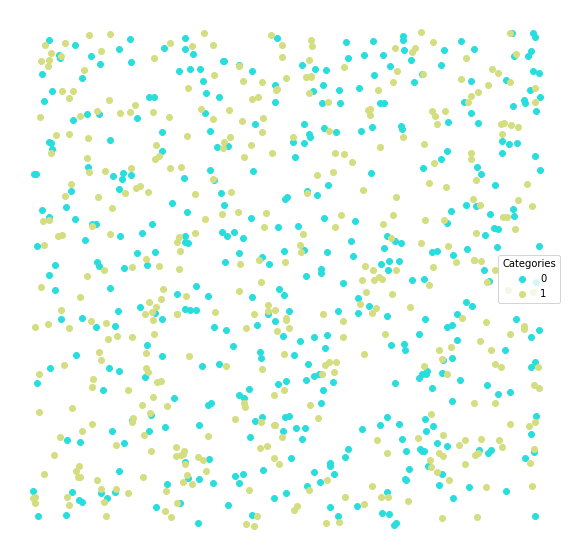

In [34]:
lucem_illud_2020.plotter(dfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [35]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

We're using sklearn here. What is sklearn? It's an open source machine learning library for Python. We use sklearn because it features various machine learning algorithms and it works well with NumPy library. You don't need to understand the sklearn package in detail for the moment, but let's see what methods and attributes sklearn has, because we're going to use some of them:

In [36]:
dir(sklearn)

['__SKLEARN_SETUP__',
 '__all__',
 '__builtins__',
 '__cached__',
 '__check_build',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_config',
 '_distributor_init',
 '_loss',
 'base',
 'clone',
 'config_context',
 'datasets',
 'decomposition',
 'dummy',
 'ensemble',
 'exceptions',
 'externals',
 'feature_extraction',
 'get_config',
 'linear_model',
 'logger',
 'logging',
 'metrics',
 'model_selection',
 'naive_bayes',
 'neighbors',
 'neural_network',
 'os',
 'preprocessing',
 'set_config',
 'setup_module',
 'show_versions',
 'svm',
 'sys',
 'tree',
 'utils']

Now we fit the model by giving it our training data

In [37]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

KNeighborsClassifier(weights='distance')

Here, "stack" function is used. Why did we use stack function here? This is because dfTrain['vect'] is a sequence, while clf.fit() takes an array element. Let's see what dfTrain['vect'] looks like:

In [38]:
dfTrain['vect']

545    [-0.0708835575148421, -0.13130009730122283]
754     [-0.6081099246489308, -0.5731750558149615]
559     [-0.9561688191535798, -0.7897564686317304]
281        [0.07693862410113916, 0.80819564024844]
471      [-0.9390633692549273, 0.8548505440772465]
                          ...                     
779       [0.4222651896798184, 0.2546311513214017]
853    [-0.47321719481238134, -0.8577573623140069]
431     [-0.7709959895018828, -0.1723281335621074]
216       [0.7283517273841111, 0.7953550247717769]
893      [0.365599080398578, 0.004820996742599615]
Name: vect, Length: 800, dtype: object

And let's see what np.stack(dfTrain['vect']) does:

In [39]:
np.stack(dfTrain['vect'])

array([[-0.07088356, -0.1313001 ],
       [-0.60810992, -0.57317506],
       [-0.95616882, -0.78975647],
       ...,
       [-0.77099599, -0.17232813],
       [ 0.72835173,  0.79535502],
       [ 0.36559908,  0.004821  ]])

As you can see, stack function takes a sequence of arrays (which have the same shape) and joins them along a new axis.

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [40]:
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.495,0.504006,0.484211,0.482018,0.479167
1,0.495,0.504006,0.523810,0.522015,0.528846


This lets us look at which classes do better:

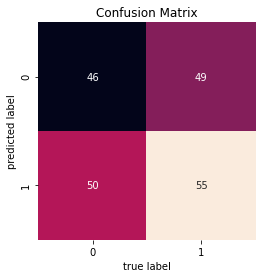

In [41]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

The greater the area under the curve the better.

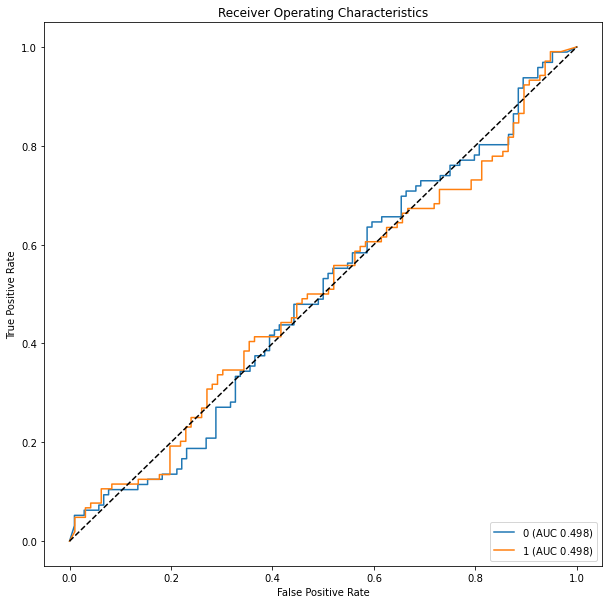

In [42]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

We can also look at the regions the classifer identifies as one class or the other:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


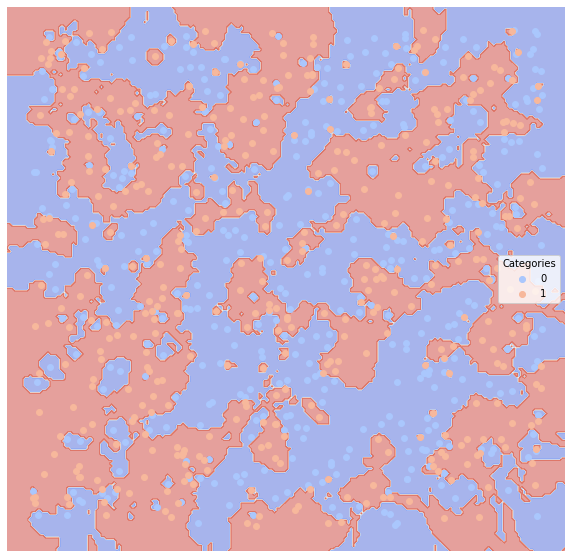

In [43]:
lucem_illud_2020.plotregions(clf, dfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [280]:
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateLarge())
#dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSpam())

Loading Reddit data
Converting to vectors


In [19]:
#Bayes
clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
#clf = sklearn.ensemble.GradientBoostingClassifier()

In [20]:
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])

GaussianNB()

In [47]:
display(lucem_illud_2020.evaluateClassifier(clf, dfTest))

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.495,0.504006,0.484211,0.482018,0.479167
1,0.495,0.504006,0.523810,0.522015,0.528846


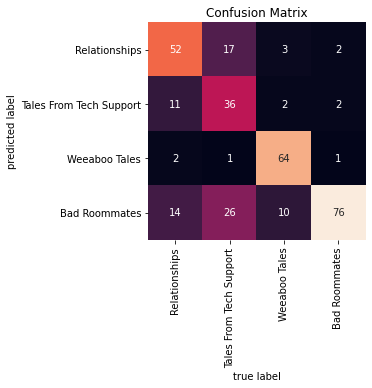

In [22]:
lucem_illud_2020.plotConfusionMatrix(clf, dfTest)

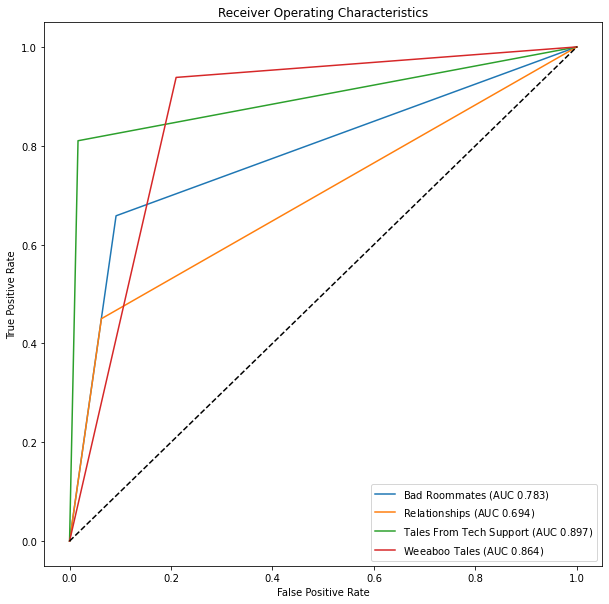

In [23]:
lucem_illud_2020.plotMultiROC(clf, dfTest)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

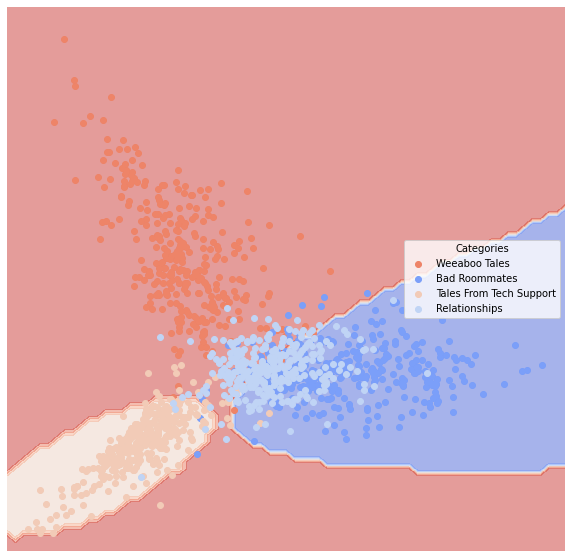

In [24]:
lucem_illud_2020.plotregions(clf, dfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

In [287]:
# 10 distinct artifical datasets
art_data = {'Random Split': lucem_illud_2020.trainTestSplit(lucem_illud_2020.random()),
           'Linear Split: 0.2 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(0.2)),
           'Linear Split: 0.7 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(0.7)),
           'Linear Split: 0.5 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.andSplit(0.5)),
           'Opposite Split: 0.2 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(0.2)),
           'Opposite Split: 0.5 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.xorSplit(0.5)),
           'Target Split: 0.2 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(0.2)),
           'Target Split: 0.5 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(0.5)),
           'MultiBlob Split: 0.2 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(0.2)),
           'MultiBlob Split: 0.5 Noise': lucem_illud_2020.trainTestSplit(lucem_illud_2020.multiBlobs(0.5))}

In [307]:
def evaluate_classifiers(dfTrain, dfTest):
    '''
    Takes data and runs it through 9 different clasifiers.
    '''
    models = {'Naive Bayes': sklearn.naive_bayes.GaussianNB(),
             'Linear SVC': sklearn.svm.SVC(kernel = 'linear', probability = True),
             'Poly SVC': sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True),
             'Nearest Neighbors (k=5)': sklearn.neighbors.KNeighborsClassifier(5, weights='distance'),
             'Logistic Regression': sklearn.linear_model.LogisticRegression(),
             'Decision Tree': sklearn.tree.DecisionTreeClassifier(),
             'Random Forest': sklearn.ensemble.RandomForestClassifier(),
             'Neural Network': sklearn.neural_network.MLPClassifier(),
             'Gradient Boost Ensemble': sklearn.ensemble.GradientBoostingClassifier()}
    for clf_name, clf in models.items():
        clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
        print(clf_name)
        print('accuracy score: ', sklearn.metrics.accuracy_score(dfTest['category'],clf.predict(np.stack(dfTest['vect'], axis = 0))))
        display(lucem_illud_2020.evaluateClassifier(clf, dfTest))


In [296]:
for data_name, (dfTrain, dfTest) in art_data.items():
    print('Data: ', data_name)
    evaluate_classifiers(dfTrain, dfTest)

Data:  Random Split
Naive Bayes
accuracy score:  0.48


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.52,0.483541,0.455357,0.462055,0.542553
1,0.52,0.483541,0.511364,0.522088,0.424528


Linear SVC
accuracy score:  0.47


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.53,0.5,0.47,0.47,1.0
1,0.53,0.5,0.00,0.53,0.0


Poly SVC
accuracy score:  0.56


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.44,0.575271,0.52,0.511489,0.829787
1,0.44,0.575271,0.68,0.578113,0.320755


Nearest Neighbors (k=5)
accuracy score:  0.49


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.51,0.489964,0.46,0.465106,0.489362
1,0.51,0.489964,0.52,0.525094,0.490566


Logistic Regression
accuracy score:  0.5


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.5,0.51385,0.479452,0.477039,0.744681
1,0.5,0.51385,0.555556,0.537233,0.283019


Decision Tree
accuracy score:  0.54


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.46,0.53894,0.510417,0.491068,0.521277
1,0.46,0.53894,0.567308,0.550766,0.556604


Random Forest
accuracy score:  0.48


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.52,0.482939,0.454545,0.461779,0.531915
1,0.52,0.482939,0.511111,0.521803,0.433962


Neural Network
accuracy score:  0.495


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.505,0.495283,0.465347,0.467673,0.500000
1,0.505,0.495283,0.525253,0.527671,0.490566


Gradient Boost Ensemble
accuracy score:  0.575


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.425,0.576174,0.543689,0.513900,0.595745
1,0.425,0.576174,0.608247,0.573553,0.556604


Data:  Linear Split: 0.2 Noise
Naive Bayes
accuracy score:  0.9


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.899248,0.903226,0.853642,0.884211
1,0.1,0.899248,0.897196,0.865294,0.914286


Linear SVC
accuracy score:  0.905


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.904511,0.904255,0.859071,0.894737
1,0.095,0.904511,0.905660,0.873032,0.914286


Poly SVC
accuracy score:  0.91


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.09,0.911278,0.881188,0.855534,0.936842
1,0.09,0.911278,0.939394,0.892035,0.885714


Nearest Neighbors (k=5)
accuracy score:  0.91


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.09,0.909774,0.905263,0.864501,0.905263
1,0.09,0.909774,0.914286,0.880918,0.914286


Logistic Regression
accuracy score:  0.9


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.899248,0.903226,0.853642,0.884211
1,0.1,0.899248,0.897196,0.865294,0.914286


Decision Tree
accuracy score:  0.915


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.085,0.91604,0.89,0.863789,0.936842
1,0.085,0.91604,0.94,0.896524,0.895238


Random Forest
accuracy score:  0.895


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.105,0.89599,0.87,0.836737,0.915789
1,0.105,0.89599,0.92,0.871095,0.876190


Neural Network
accuracy score:  0.9


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.1,0.899248,0.903226,0.853642,0.884211
1,0.1,0.899248,0.897196,0.865294,0.914286


Gradient Boost Ensemble
accuracy score:  0.905


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.906015,0.88,0.850158,0.926316
1,0.095,0.906015,0.93,0.883714,0.885714


Data:  Linear Split: 0.7 Noise
Naive Bayes
accuracy score:  0.595


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.405,0.596742,0.627660,0.582685,0.561905
1,0.405,0.596742,0.566038,0.532498,0.631579


Linear SVC
accuracy score:  0.6


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.4,0.602005,0.634409,0.586477,0.561905
1,0.4,0.602005,0.570093,0.536060,0.642105


Poly SVC
accuracy score:  0.58


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.42,0.588471,0.656716,0.580195,0.419048
1,0.42,0.588471,0.541353,0.525289,0.757895


Nearest Neighbors (k=5)
accuracy score:  0.555


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.445,0.56015,0.600,0.559286,0.457143
1,0.445,0.56015,0.525,0.508158,0.663158


Logistic Regression
accuracy score:  0.595


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.405,0.597243,0.630435,0.583240,0.552381
1,0.405,0.597243,0.564815,0.532671,0.642105


Decision Tree
accuracy score:  0.5


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.5,0.498246,0.523364,0.524128,0.533333
1,0.5,0.498246,0.473118,0.474128,0.463158


Random Forest
accuracy score:  0.56


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.44,0.5599,0.584158,0.558241,0.561905
1,0.44,0.5599,0.535354,0.508671,0.557895


Neural Network
accuracy score:  0.61


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.39,0.611529,0.642105,0.593033,0.580952
1,0.39,0.611529,0.580952,0.543033,0.642105


Gradient Boost Ensemble
accuracy score:  0.575


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.425,0.575188,0.60,0.567857,0.571429
1,0.425,0.575188,0.55,0.518421,0.578947


Data:  Linear Split: 0.5 Noise
Naive Bayes
accuracy score:  0.745


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.255,0.744565,0.771429,0.713571,0.75000
1,0.255,0.744565,0.715789,0.649062,0.73913


Linear SVC
accuracy score:  0.745


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.255,0.74537,0.776699,0.715333,0.740741
1,0.255,0.74537,0.711340,0.648505,0.750000


Poly SVC
accuracy score:  0.75


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.25,0.755636,0.822222,0.733374,0.685185
1,0.25,0.755636,0.690909,0.650751,0.826087


Nearest Neighbors (k=5)
accuracy score:  0.725


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.275,0.728462,0.778947,0.703723,0.685185
1,0.275,0.728462,0.676190,0.626843,0.771739


Logistic Regression
accuracy score:  0.745


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.255,0.744565,0.771429,0.713571,0.75000
1,0.255,0.744565,0.715789,0.649062,0.73913


Decision Tree
accuracy score:  0.73


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.27,0.731481,0.77,0.703981,0.712963
1,0.27,0.731481,0.69,0.632500,0.750000


Random Forest
accuracy score:  0.75


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.25,0.75161,0.79,0.722870,0.731481
1,0.25,0.75161,0.71,0.652935,0.771739


Neural Network
accuracy score:  0.74


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.26,0.73913,0.764151,0.708113,0.750000
1,0.26,0.73913,0.712766,0.644080,0.728261


Gradient Boost Ensemble
accuracy score:  0.74


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.26,0.739936,0.769231,0.709801,0.740741
1,0.26,0.739936,0.708333,0.643551,0.739130


Data:  Opposite Split: 0.2 Noise
Naive Bayes
accuracy score:  0.43


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.57,0.434085,0.445783,0.497085,0.352381
1,0.57,0.434085,0.418803,0.446014,0.515789


Linear SVC
accuracy score:  0.625


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.375,0.614286,0.604167,0.590595,0.828571
1,0.375,0.614286,0.678571,0.556429,0.400000


Poly SVC
accuracy score:  0.66


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.34,0.670677,0.813559,0.656913,0.457143
1,0.34,0.670677,0.595745,0.581764,0.884211


Nearest Neighbors (k=5)
accuracy score:  0.905


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.906015,0.93,0.883714,0.885714
1,0.095,0.906015,0.88,0.850158,0.926316


Logistic Regression
accuracy score:  0.41


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.59,0.41203,0.428571,0.489184,0.371429
1,0.59,0.41203,0.394495,0.438561,0.452632


Decision Tree
accuracy score:  0.885


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.884461,0.886792,0.848890,0.895238
1,0.115,0.884461,0.882979,0.831445,0.873684


Random Forest
accuracy score:  0.895


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.105,0.894486,0.896226,0.860872,0.904762
1,0.105,0.894486,0.893617,0.845146,0.884211


Neural Network
accuracy score:  0.94


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.06,0.941353,0.969697,0.931580,0.914286
1,0.06,0.941353,0.910891,0.897126,0.968421


Gradient Boost Ensemble
accuracy score:  0.89


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.889724,0.895238,0.856451,0.895238
1,0.11,0.889724,0.884211,0.836828,0.884211


Data:  Opposite Split: 0.5 Noise
Naive Bayes
accuracy score:  0.49


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.51,0.50562,0.473684,0.472822,0.765957
1,0.51,0.50562,0.541667,0.532862,0.245283


Linear SVC
accuracy score:  0.47


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.53,0.5,0.47,0.47,1.0
1,0.53,0.5,0.00,0.53,0.0


Poly SVC
accuracy score:  0.75


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.25,0.741269,0.823529,0.680613,0.595745
1,0.25,0.741269,0.712121,0.691504,0.886792


Nearest Neighbors (k=5)
accuracy score:  0.77


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.23,0.767965,0.766667,0.687766,0.734043
1,0.23,0.767965,0.772727,0.724640,0.801887


Logistic Regression
accuracy score:  0.585


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.415,0.599458,0.537415,0.526657,0.840426
1,0.415,0.599458,0.716981,0.597031,0.358491


Decision Tree
accuracy score:  0.77


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.23,0.770373,0.744898,0.683485,0.776596
1,0.23,0.770373,0.794118,0.731826,0.764151


Random Forest
accuracy score:  0.81


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.19,0.808711,0.804348,0.73321,0.787234
1,0.19,0.808711,0.814815,0.76645,0.830189


Neural Network
accuracy score:  0.835


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.165,0.835909,0.808081,0.757728,0.851064
1,0.165,0.835909,0.861386,0.801987,0.820755


Gradient Boost Ensemble
accuracy score:  0.805


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.195,0.803392,0.802198,0.727983,0.776596
1,0.195,0.803392,0.807339,0.760244,0.830189


Data:  Target Split: 0.2 Noise
Naive Bayes
accuracy score:  0.915


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.085,0.915,0.880734,0.865505,0.96
1,0.085,0.915,0.956044,0.896758,0.87


Linear SVC
accuracy score:  0.62


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.38,0.62,0.578947,0.569474,0.88
1,0.38,0.62,0.750000,0.590000,0.36


Poly SVC
accuracy score:  0.525


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.475,0.525,0.512821,0.512821,1.00
1,0.475,0.525,1.000000,0.525000,0.05


Nearest Neighbors (k=5)
accuracy score:  0.89


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.11,0.89,0.897959,0.850204,0.88
1,0.11,0.89,0.882353,0.844118,0.90


Logistic Regression
accuracy score:  0.495


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.505,0.495,0.494845,0.497526,0.48
1,0.505,0.495,0.495146,0.497524,0.51


Decision Tree
accuracy score:  0.85


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.15,0.85,0.880435,0.808152,0.81
1,0.15,0.85,0.824074,0.788426,0.89


Random Forest
accuracy score:  0.885


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.885,0.896907,0.845309,0.87
1,0.115,0.885,0.873786,0.836408,0.90


Neural Network
accuracy score:  0.905


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.095,0.905,0.864865,0.850270,0.96
1,0.095,0.905,0.955056,0.886798,0.85


Gradient Boost Ensemble
accuracy score:  0.885


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.115,0.885,0.888889,0.842222,0.88
1,0.115,0.885,0.881188,0.839257,0.89


Data:  Target Split: 0.5 Noise
Naive Bayes
accuracy score:  0.725


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.275,0.721899,0.725664,0.681362,0.773585
1,0.275,0.721899,0.724138,0.640326,0.670213


Linear SVC
accuracy score:  0.47


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.53,0.5,0.00,0.53,0.0
1,0.53,0.5,0.47,0.47,1.0


Poly SVC
accuracy score:  0.47


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.53,0.5,0.00,0.53,0.0
1,0.53,0.5,0.47,0.47,1.0


Nearest Neighbors (k=5)
accuracy score:  0.625


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.375,0.621538,0.637168,0.602793,0.679245
1,0.375,0.621538,0.609195,0.548483,0.563830


Logistic Regression
accuracy score:  0.36


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.64,0.373946,0.288462,0.495820,0.141509
1,0.64,0.373946,0.385135,0.418539,0.606383


Decision Tree
accuracy score:  0.68


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.32,0.678844,0.698113,0.647362,0.698113
1,0.32,0.678844,0.659574,0.595038,0.659574


Random Forest
accuracy score:  0.715


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.285,0.710056,0.705882,0.669378,0.792453
1,0.285,0.710056,0.728395,0.632184,0.627660


Neural Network
accuracy score:  0.725


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.275,0.722501,0.729730,0.682624,0.764151
1,0.275,0.722501,0.719101,0.639601,0.680851


Gradient Boost Ensemble
accuracy score:  0.715


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.285,0.710658,0.709402,0.670475,0.783019
1,0.285,0.710658,0.722892,0.631420,0.638298


Data:  MultiBlob Split: 0.2 Noise
Naive Bayes
accuracy score:  0.896


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.004,0.993703,0.989899,0.981900,0.989899
1,0.082,0.863151,0.824742,0.682417,0.769231
2,0.018,0.964391,0.967033,0.917307,0.936170
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.104,0.853291,0.710280,0.598508,0.783505


Linear SVC
accuracy score:  0.896


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.008,0.991209,0.970297,0.962496,0.989899
1,0.078,0.872766,0.828283,0.697069,0.788462
2,0.018,0.964391,0.967033,0.917307,0.936170
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.104,0.845463,0.718447,0.594093,0.762887


Poly SVC
accuracy score:  0.886


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.010,0.989962,0.960784,0.953079,0.989899
1,0.086,0.849990,0.827957,0.667007,0.740385
2,0.018,0.960303,0.977528,0.918733,0.925532
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.114,0.843174,0.681818,0.571179,0.773196


Nearest Neighbors (k=5)
accuracy score:  0.896


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.010,0.989962,0.960784,0.953079,0.989899
1,0.086,0.846445,0.835165,0.666313,0.730769
2,0.014,0.983204,0.948454,0.932274,0.978723
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.098,0.857013,0.730769,0.614561,0.783505


Logistic Regression
accuracy score:  0.892


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.006,0.992456,0.980000,0.972101,0.989899
1,0.084,0.861888,0.816327,0.675943,0.769231
2,0.018,0.964391,0.967033,0.917307,0.936170
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.108,0.842982,0.704762,0.583653,0.762887


Decision Tree
accuracy score:  0.888


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.010,0.989962,0.960784,0.953079,0.989899
1,0.092,0.839112,0.815217,0.645897,0.721154
2,0.012,0.984436,0.958333,0.941943,0.978723
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.110,0.837827,0.701923,0.576251,0.752577


Random Forest
accuracy score:  0.908


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.008,0.991209,0.970297,0.962496,0.989899
1,0.072,0.880099,0.846939,0.717922,0.798077
2,0.014,0.979116,0.957895,0.933324,0.968085
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.090,0.861976,0.760000,0.637464,0.783505


Neural Network
accuracy score:  0.902


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.004,0.993703,0.989899,0.981900,0.989899
1,0.084,0.858343,0.822917,0.675100,0.759615
2,0.010,0.981579,0.978495,0.953266,0.968085
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.098,0.860927,0.726415,0.616639,0.793814


Gradient Boost Ensemble
accuracy score:  0.886


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.004,0.993703,0.989899,0.981900,0.989899
1,0.098,0.838869,0.783505,0.628561,0.730769
2,0.012,0.976260,0.978261,0.944633,0.957447
3,0.000,1.000000,1.000000,1.000000,1.000000
4,0.114,0.835346,0.688679,0.566284,0.752577


Data:  MultiBlob Split: 0.5 Noise
Naive Bayes
accuracy score:  0.836


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.020,0.971741,0.938776,0.907660,0.958333
1,0.064,0.905399,0.864865,0.768752,0.849558
2,0.098,0.837827,0.793814,0.634639,0.726415
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.144,0.777778,0.590000,0.448778,0.655556


Linear SVC
accuracy score:  0.836


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.018,0.976949,0.939394,0.916038,0.968750
1,0.064,0.902266,0.871560,0.768727,0.840708
2,0.098,0.837827,0.793814,0.634639,0.726415
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.146,0.776558,0.584158,0.444948,0.655556


Poly SVC
accuracy score:  0.802


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.024,0.957354,0.946809,0.891770,0.927083
1,0.088,0.830372,0.905882,0.689283,0.681416
2,0.116,0.853989,0.696721,0.600692,0.801887
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.166,0.751355,0.533333,0.399852,0.622222


Nearest Neighbors (k=5)
accuracy score:  0.792


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.018,0.972979,0.948454,0.916935,0.958333
1,0.090,0.854142,0.833333,0.682844,0.752212
2,0.126,0.795925,0.721649,0.548561,0.660377
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.180,0.738482,0.500000,0.375556,0.611111


Logistic Regression
accuracy score:  0.838


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.016,0.982158,0.940000,0.924417,0.979167
1,0.066,0.904107,0.857143,0.762192,0.849558
2,0.094,0.840365,0.810526,0.646779,0.726415
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.146,0.772222,0.585859,0.441553,0.644444


Decision Tree
accuracy score:  0.748


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.032,0.948432,0.916667,0.856278,0.916667
1,0.118,0.817258,0.759615,0.599059,0.699115
2,0.142,0.761637,0.692308,0.497466,0.594340
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.210,0.698509,0.434783,0.321546,0.555556


Random Forest
accuracy score:  0.804


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.022,0.974474,0.920792,0.898017,0.968750
1,0.078,0.877558,0.849057,0.722240,0.796460
2,0.120,0.803180,0.739583,0.565381,0.669811
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.170,0.740244,0.524272,0.386563,0.600000


Neural Network
accuracy score:  0.834


/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.020,0.975712,0.930000,0.906938,0.968750
1,0.066,0.897841,0.870370,0.762025,0.831858
2,0.098,0.834379,0.800000,0.633585,0.716981
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.146,0.780894,0.582524,0.448350,0.666667


Gradient Boost Ensemble
accuracy score:  0.8


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.026,0.968028,0.910891,0.880937,0.958333
1,0.086,0.866125,0.830189,0.696519,0.778761
2,0.114,0.806987,0.763441,0.581361,0.669811
3,0.002,0.994737,1.000000,0.991474,0.989474
4,0.172,0.743360,0.518868,0.387086,0.611111


The gradient boost appeared to work the best on the randomly split artificial dataset, which makes sense because it works well on non-linear boundaries. The linear SVC worked well on all of the linear splits because it is generally robust to noise. Neural networks did well on the opposite split data of both noise levels because they can pick up on more complex relationships between features. Naive Bayes performed the best on the target split (though neural network also did well on the noisy target split) because it uses posterior probabilities which were able to pick up on the nuanced relationships of our classes nested within dimensions. Finally, random forest performed the best on our multiblob datasets, which makes sense as it's able to run different classifiers and take a majority vote, which can ensure greater accuracy when there are many options for classification,

In [299]:
reddit_train, reddit_test = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadReddit())
news_train, news_test = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadNewsGroups())
senate_small_train, senate_small_test = lucem_illud_2020.trainTestSplit(lucem_illud_2020.loadSenateSmall())

Loading Reddit data
Converting to vectors
Loading data for: comp.sys.mac.hardware
Loading data for: comp.windows.x
Loading data for: misc.forsale
Loading data for: rec.autos
Converting to vectors
Loading senate data
Converting to vectors


FileNotFoundError: [Errno 2] No such file or directory: '../data/grimmerPressReleases'

In [302]:
real_data = {'Reddit': (reddit_train, reddit_test),
            'News Groups': (news_train, news_test),
            'Senate Small': (senate_small_train, senate_small_test)}

In [303]:
for data_name, (dfTrain, dfTest) in real_data.items():
    print('Data: ', data_name)
    evaluate_classifiers(dfTrain, dfTest)

Data:  Reddit
Naive Bayes
accuracy score:  0.7115987460815048


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.172414,0.872238,0.600000,0.587182,0.962963
Bad Roommates,0.166144,0.743210,0.741935,0.527181,0.554217
Tales From Tech Support,0.072100,0.890601,0.891892,0.773749,0.814815
Relationships,0.166144,0.717347,0.698113,0.465044,0.500000


Linear SVC
accuracy score:  0.9843260188087775


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.000000,1.000000,1.000000,1.000000,1.000000
Bad Roommates,0.015674,0.969880,1.000000,0.955433,0.939759
Tales From Tech Support,0.003135,0.997899,0.987805,0.987805,1.000000
Relationships,0.012539,0.991837,0.948718,0.948718,1.000000


Poly SVC
accuracy score:  0.8996865203761756


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.025078,0.950617,1.000000,0.926313,0.901235
Bad Roommates,0.075235,0.855422,1.000000,0.786078,0.710843
Tales From Tech Support,0.068966,0.953782,0.786408,0.786408,1.000000
Relationships,0.031348,0.979592,0.880952,0.880952,1.000000


Nearest Neighbors (k=5)
accuracy score:  0.896551724137931


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.062696,0.953911,0.808081,0.801239,0.987654
Bad Roommates,0.047022,0.929166,0.935897,0.854487,0.879518
Tales From Tech Support,0.025078,0.962833,0.962025,0.918315,0.938272
Relationships,0.072100,0.872890,0.904762,0.750203,0.770270


Logistic Regression
accuracy score:  0.9749216300940439


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.003135,0.997899,0.987805,0.987805,1.000000
Bad Roommates,0.025078,0.959618,0.974684,0.923033,0.927711
Tales From Tech Support,0.003135,0.997899,0.987805,0.987805,1.000000
Relationships,0.018809,0.978323,0.947368,0.928033,0.972973


Decision Tree
accuracy score:  0.9028213166144201


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.037618,0.970718,0.879121,0.871402,0.987654
Bad Roommates,0.056426,0.914999,0.922078,0.826383,0.855422
Tales From Tech Support,0.068966,0.913062,0.855422,0.781162,0.876543
Relationships,0.031348,0.941864,0.970588,0.890738,0.891892


Random Forest
accuracy score:  0.9529780564263323


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.015674,0.985424,0.952381,0.943758,0.987654
Bad Roommates,0.034483,0.953262,0.939024,0.889952,0.927711
Tales From Tech Support,0.015674,0.973208,0.987179,0.950969,0.950617
Relationships,0.028213,0.962769,0.933333,0.895422,0.945946


Neural Network
accuracy score:  0.9749216300940439


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.009404,0.993697,0.964286,0.964286,1.000000
Bad Roommates,0.018809,0.963855,1.000000,0.946520,0.927711
Tales From Tech Support,0.006270,0.991726,0.987654,0.978596,0.987654
Relationships,0.015674,0.985080,0.948052,0.938375,0.986486


Gradient Boost Ensemble
accuracy score:  0.9655172413793104


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.012539,0.983453,0.975309,0.957497,0.975309
Bad Roommates,0.028213,0.949689,0.986842,0.916803,0.903614
Tales From Tech Support,0.021944,0.985294,0.920455,0.920455,1.000000
Relationships,0.006270,0.991202,0.986486,0.976290,0.986486


Data:  News Groups
Naive Bayes
accuracy score:  0.8063829787234043


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.038298,0.960473,0.897638,0.870560,0.957983
comp.sys.mac.hardware,0.121277,0.842396,0.715517,0.606091,0.775701
rec.autos,0.106383,0.847543,0.859649,0.710565,0.742424
misc.forsale,0.121277,0.834497,0.743363,0.617097,0.750000


Linear SVC
accuracy score:  0.8829787234042553


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.036170,0.959120,0.911290,0.878109,0.949580
comp.sys.mac.hardware,0.059574,0.912000,0.876190,0.785275,0.859813
rec.autos,0.076596,0.919042,0.833333,0.783108,0.909091
misc.forsale,0.061702,0.892009,0.927835,0.792390,0.803571


Poly SVC
accuracy score:  0.8382978723404255


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.061702,0.892037,0.950000,0.809467,0.798319
comp.sys.mac.hardware,0.070213,0.875454,0.902174,0.750881,0.775701
rec.autos,0.117021,0.904788,0.720000,0.700039,0.954545
misc.forsale,0.074468,0.883629,0.873786,0.748958,0.803571


Nearest Neighbors (k=5)
accuracy score:  0.274468085106383


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.227660,0.550420,1.000000,0.328500,0.100840
comp.sys.mac.hardware,0.519149,0.456296,0.195556,0.214458,0.411215
rec.autos,0.465957,0.514434,0.293839,0.286951,0.469697
misc.forsale,0.238298,0.533744,0.500000,0.264001,0.098214


Logistic Regression
accuracy score:  0.8957446808510638


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.027660,0.970373,0.927419,0.904756,0.966387
comp.sys.mac.hardware,0.053191,0.919428,0.894231,0.807016,0.869159
rec.autos,0.068085,0.929577,0.847222,0.804315,0.924242
misc.forsale,0.059574,0.896473,0.928571,0.799145,0.812500


Decision Tree
accuracy score:  0.6957446808510638


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.136170,0.844957,0.700730,0.614231,0.806723
comp.sys.mac.hardware,0.146809,0.759957,0.715909,0.515134,0.588785
rec.autos,0.182979,0.785055,0.661972,0.552255,0.712121
misc.forsale,0.142553,0.789854,0.718447,0.555539,0.660714


Random Forest
accuracy score:  0.8297872340425532


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.072340,0.926572,0.814815,0.772339,0.924370
comp.sys.mac.hardware,0.076596,0.861435,0.898876,0.729504,0.747664
rec.autos,0.104255,0.885960,0.786207,0.717295,0.863636
misc.forsale,0.087234,0.862979,0.851485,0.709138,0.767857


Neural Network
accuracy score:  0.8957446808510638


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.023404,0.973222,0.942623,0.919449,0.966387
comp.sys.mac.hardware,0.048936,0.922183,0.911765,0.822256,0.869159
rec.autos,0.072340,0.915075,0.860294,0.794448,0.886364
misc.forsale,0.063830,0.909018,0.872727,0.782095,0.857143


Gradient Boost Ensemble
accuracy score:  0.8106382978723404


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
comp.windows.x,0.068085,0.912758,0.859504,0.783078,0.873950
comp.sys.mac.hardware,0.112766,0.841315,0.750000,0.623076,0.757009
rec.autos,0.100000,0.879684,0.814815,0.725821,0.833333
misc.forsale,0.097872,0.855996,0.811321,0.678298,0.767857


Data:  Senate Small
Naive Bayes
accuracy score:  0.8123167155425219


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.187683,0.809064,0.800000,0.762817,0.861878
Obama,0.187683,0.809064,0.828767,0.741125,0.756250


Linear SVC
accuracy score:  0.9882697947214076


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.01173,0.9875,0.978378,0.978378,1.000
Obama,0.01173,0.9875,1.000000,0.986730,0.975


Poly SVC
accuracy score:  0.8181818181818182


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.181818,0.808425,0.757576,0.750058,0.966851
Obama,0.181818,0.808425,0.945455,0.778768,0.650000


Nearest Neighbors (k=5)
accuracy score:  0.8680351906158358


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.131965,0.866989,0.869565,0.830260,0.883978
Obama,0.131965,0.866989,0.866242,0.806687,0.850000


Logistic Regression
accuracy score:  0.9706744868035191


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.029326,0.96875,0.947644,0.947644,1.0000
Obama,0.029326,0.96875,1.000000,0.966826,0.9375


Decision Tree
accuracy score:  1.0


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.0,1.0,1.0,1.0,1.0
Obama,0.0,1.0,1.0,1.0,1.0


Random Forest
accuracy score:  0.9912023460410557


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.008798,0.990625,0.983696,0.983696,1.00000
Obama,0.008798,0.990625,1.000000,0.990048,0.98125


Neural Network
accuracy score:  0.9354838709677419


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.064516,0.934876,0.934426,0.912126,0.944751
Obama,0.064516,0.934876,0.936709,0.901646,0.925000


Gradient Boost Ensemble
accuracy score:  1.0


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Clinton,0.0,1.0,1.0,1.0,1.0
Obama,0.0,1.0,1.0,1.0,1.0


The Linear SVC performed the best on the Reddit dataset with an accuracy of 0.98. The logistic regression and neural network performed well on the News Group dataset (with accuracies of about 0.89). The decision tree was a perfect classifier on the Senate dataset. This is probably because the Senate dataset had very distinctive criteria.

Stretch: apply adaboost to one artificial dataset and to Reddit dataset.

In [311]:
clf = sklearn.ensemble.AdaBoostClassifier()
dfTrain, dfTest = lucem_illud_2020.trainTestSplit(lucem_illud_2020.targetSplit(0.5))
clf.fit(np.stack(dfTrain['vect'], axis=0), dfTrain['category'])
lucem_illud_2020.evaluateClassifier(clf, dfTest)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.25,0.746366,0.735043,0.697035,0.819048
1,0.25,0.746366,0.771084,0.674467,0.673684


In [312]:
clf = sklearn.ensemble.AdaBoostClassifier()
clf.fit(np.stack(reddit_train['vect'], axis=0), reddit_train['category'])
lucem_illud_2020.evaluateClassifier(clf, reddit_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Weeaboo Tales,0.037618,0.954430,0.915663,0.874814,0.938272
Bad Roommates,0.081505,0.862901,0.925373,0.757073,0.746988
Tales From Tech Support,0.062696,0.945767,0.821053,0.800048,0.962963
Relationships,0.056426,0.920822,0.878378,0.799762,0.878378


In [313]:
print('accuracy score: ', sklearn.metrics.accuracy_score(reddit_test['category'],clf.predict(np.stack(reddit_test['vect'], axis = 0))))


accuracy score:  0.8808777429467085


For the artificial data (the target split with 0.5 noise), the ADAboost performs better than all of the other classifiers. ADAboost may be especially good at identifying target-split data because it combines statistical power from an ensemble of classifiers. The ADAboost performs significantly worse on the reddit data than its best classifier, the Linear SVC (0.88 for ADAboost accuracy compared to 0.98 with the SVC). For this dataset, ADAboost is outperformed by all of the classifiers except Naive Bayes. ADAboost may not be the best choice here because it is prone to overfitting on noisier datasets, and it is plausible that our Reddit dataset contains a good bit of noise. 

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [25]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

I'm pretty sure that you're all familiar with pandas, but, just to clarify: why do we use pandas here? pandas is a Python library which is widely used for analyzing and wrangling data. In particular, pandas loads data and creates data frame, a Python object that looks familiar to us (since it looks like a excel table) and easy to work with. So, using pandas.read_csv function, we take in the csv file and convert it into a data frame. 

In [26]:
type(ObamaClintonReleases)

pandas.core.frame.DataFrame

It's a DataFrame! and it looks like this:

In [27]:
ObamaClintonReleases

,download_url,html_url,name,path,text,targetSenator
0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2007Obama430.txt,raw/Obama/10Apr2007Obama430.txt,Obama Calls on IRS to Protect Taxpayers ...,Obama
1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Apr2008Obama108.txt,raw/Obama/10Apr2008Obama108.txt,Statement from Senator Barack Obama on the ...,Obama
2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama674.txt,raw/Obama/10Aug2005Obama674.txt,Obama Says Bill Will Help Cut Off Supply of...,Obama
3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2005Obama675.txt,raw/Obama/10Aug2005Obama675.txt,Obama Durbin Say Illinois Will Receive 33 ...,Obama
4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,10Aug2006Obama508.txt,raw/Obama/10Aug2006Obama508.txt,Obama Introduces Bill to Help Tap Power of ...,Obama
...,...,...,...,...,...,...
1704,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton285.txt,raw/Clinton/1Sep2005Clinton285.txt,September 1 2005 Senator Clinton Visit Infoto...,Clinton
1705,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton286.txt,raw/Clinton/1Sep2005Clinton286.txt,September 1 2005 Senator Clinton Announces Ex...,Clinton
1706,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2005Clinton287.txt,raw/Clinton/1Sep2005Clinton287.txt,September 1 2005 Senator Clinton Joins Local ...,Clinton
1707,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,1Sep2006Clinton207.txt,raw/Clinton/1Sep2006Clinton207.txt,September 1 2006 Clintons Meet with Cazenovia...,Clinton


Neat! Let's turn the 'targetSenator' column into a binary category variable.

In [28]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [29]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Let's split the data into training data and testing data.

In [30]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [31]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud_2020.generateVecs()` will help with this but for now we are doing it the long way):

In [48]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

The core function here is TfidfVectorizer, which takes a collection of raw documents and turn them to a tf-idf matrix. Just to recap: tf-idf means term frequency-inverse document frequency, a statistic (or, more precisely, a product of two statistics, term frequency and inverse document frequency) that shows the importance of a term vis-a-vis documents. TF, or, term frequency, counts how many times a term is used in a document; IDF, or, inverse-document-frequency, measures common or rare a term appears across documents. 

Let's look at three parameters of TfidfVectorizer: max_df = 100, min_df = 2, and norm='l2'. What do those parameters mean? 

(1) max_df = 100

Here, we specified a thredhold of 100, and the terms that have a document frequency higher than 100 would be ignored.

(2) min_df = 2

We specified a lower bound, 2, and the terms that have a document frequency lower than 2 will be ignored.

(3) norm = 'l2'

This parameter is about vector normalization. In machine learning, we commonly normalize vectors, i.e., change the length of vectors and turn them into a unit vector, before passing them into algorithms. There are various ways of normalizations, and this parameter specifies how we normalize vectors. Here, we set the norm to l2, in which case, we normalize the vectors such that squares of vector elements sums to 1. Alternatively, we can set it to l1, in which case the sum of absolute values of vector elements, not the square of vector elements, is 1. 

fit_transform() literally fits to data and then transform it. So, fit_transform() is just a combination of two steps--(1) fitting parameters to data; (2) then, using the vocabulary and document frequencies learned by fit(), transforming documents into document-term matrix. So, it's the same as fit followed by transform. 

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [49]:
TFVects.shape

(1368, 11360)

We can save this in the dataframe to make things easier

In [50]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

Looks simple, but we need to know what todense() does here. todense() returns a dense matrix representation of the matrix. Why do we need this? As you can see above, the TFVects, a document-term matrix, has 11349 columns, and this matrix is sparse, in the sense that it is comprised mostly of zeros. Dense matrices, in contrast, are the matrices that are comprised of mostly non-zeros. Then why do we make sparse matrices into dense ones? Because zero values don't contain important information but take up so much memory.

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [51]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [52]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


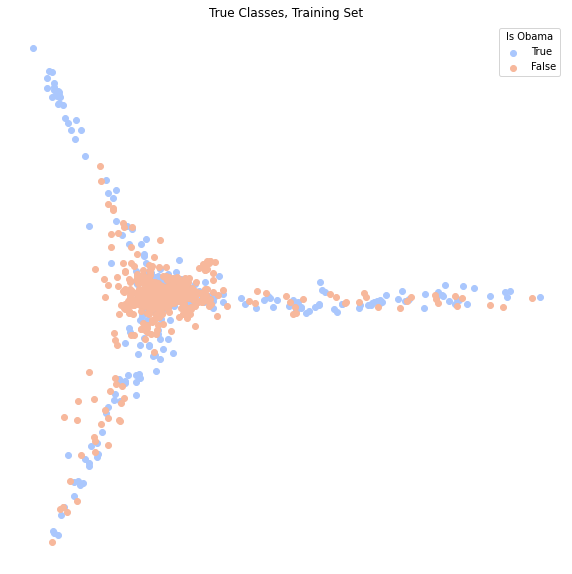

In [53]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

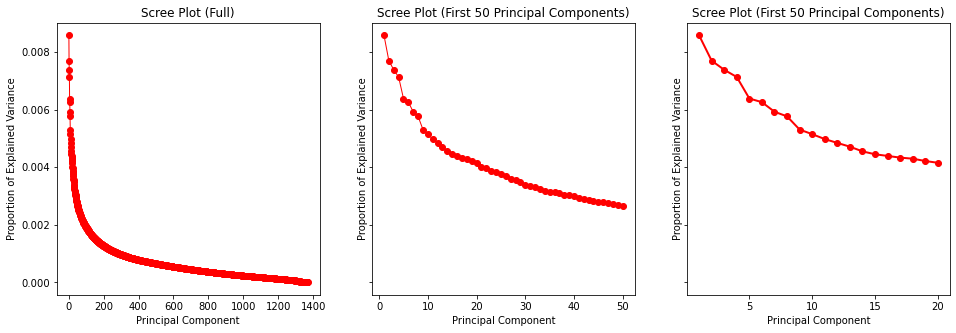

In [54]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 50 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [55]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [56]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression()

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [57]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6505847953216374

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [58]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.6832844574780058

Slightly poorer. How about using more dimensions (40)?

In [59]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7653508771929824
Testing:
0.7390029325513197


Or still more (100)?

In [60]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8369883040935673
Testing:
0.7859237536656891


Or even more (200)!

In [61]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8845029239766082
Testing:
0.8005865102639296


This is becoming ridiculous (400)!

In [62]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.929093567251462
Testing:
0.8269794721407625


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [63]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.9656432748538012


Train the model using training data, and then test it on the testing data.

In [64]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.8387096774193549


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [65]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB()

In [66]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9707602339181286
Testing:
0.8621700879765396


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [67]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [68]:
sklearn.metrics.precision_score(test_data_df['category'], test_data_df['nb_predict'])

0.8013698630136986

Recall:

In [69]:
sklearn.metrics.recall_score(test_data_df['category'], test_data_df['nb_predict'])

0.8666666666666667

F1-measure:

In [70]:
sklearn.metrics.f1_score(test_data_df['category'], test_data_df['nb_predict'])

0.8327402135231317

Let's take a look at how well our posterior distribution looks relative to the truth.

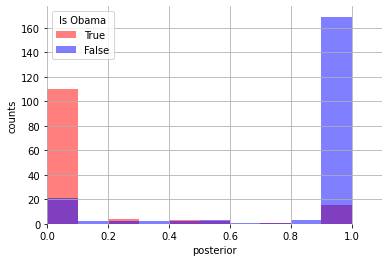

In [71]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [72]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Obama,Obama_log_prob,Clinton,Clinton_log_prob
0,welcomed,-2.272880,5566,-1.750937
1,awarded,-2.310151,dick,-1.812813
2,island,-2.348866,brundage,-1.834319
3,urging,-2.348866,chicago,-1.925291
4,continued,-2.362111,reform,-2.212973
5,announcement,-2.389140,temporary,-2.261763
6,fy,-2.389140,cases,-2.295665
7,ground,-2.431104,va,-2.295665
8,growing,-2.431104,oversight,-2.313056
9,read,-2.431104,location,-2.330756


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [73]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [74]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [75]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [76]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [77]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [78]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [79]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB()

...and save predictions to the dataframe:

In [80]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8955310504933256


In [81]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
1964,comp.graphics,comp.graphics
1036,sci.space,sci.space
883,soc.religion.christian,soc.religion.christian
1597,comp.graphics,comp.graphics
2134,comp.graphics,comp.graphics
1180,sci.space,sci.space
167,talk.religion.misc,soc.religion.christian
615,soc.religion.christian,soc.religion.christian
1264,sci.space,sci.space
53,talk.religion.misc,talk.religion.misc


Looks pretty good, lets examine the testing dataset:

In [82]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.8209302325581396


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud_2020`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

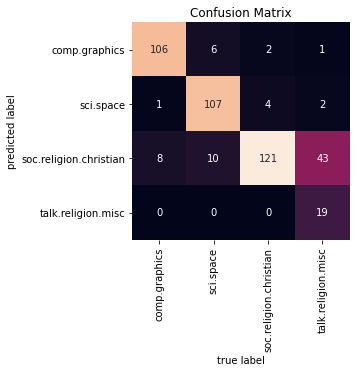

In [83]:
lucem_illud_2020.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [85]:
print(sklearn.metrics.precision_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['category'], test_ng_df['nb_predict'], average = 'weighted')) #F-1 measure

0.8625149636165549
0.8209302325581396
0.8044903167802872


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [86]:
lucem_illud_2020.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.106977,0.646154,1.000000,0.399284,0.292308
comp.graphics,0.041860,0.946584,0.921739,0.870533,0.921739
sci.space,0.053488,0.923559,0.938596,0.853712,0.869919
soc.religion.christian,0.155814,0.875718,0.664835,0.647379,0.952756


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

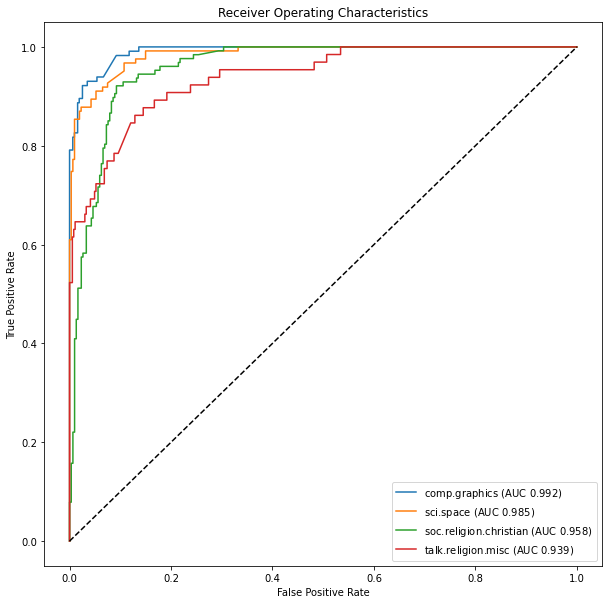

In [87]:
lucem_illud_2020.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

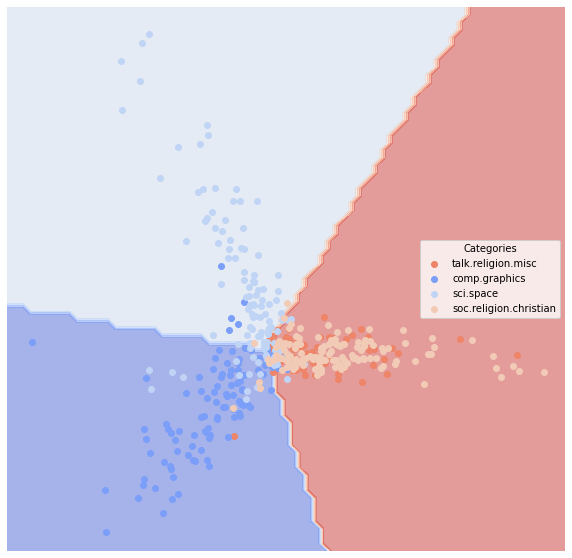

In [88]:
lucem_illud_2020.plotregions(MultinomialNB_ng, test_ng_df)

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [109]:
import pandas as pd

In [110]:
exec_orders = pd.read_csv('/Users/lilygrier/Documents/Grad_School/Computational Content Analysis/exec_orders_w_text')

In [111]:
exec_orders

,Unnamed: 0,citation,document_number,end_page,html_url,pdf_url,type,subtype,publication_date,signing_date,start_page,title,disposition_notes,executive_order_number,president,order_text
0,0,82 FR 8115,2017-01623,8129,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/23/2017,01/17/2017,8115,"Amending the Civil Service Rules, Executive Or...","Amends: EO 13467, June 30, 2008; EO 13488, Jan...",13764.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
1,1,82 FR 7619,2017-01487,7620,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/19/2017,01/13/2017,7619,Providing an Order of Succession Within the De...,"Revokes: EO 13557, November 4, 2010\nRevoked b...",13762.0,barack_obama,"\n\n\nExecutive Order 13762 of January 13, 201..."
2,2,82 FR 7621,2017-01489,7622,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/19/2017,01/13/2017,7621,Providing an Order of Succession Within the En...,"Revokes: EO 13737, August 12, 2016",13763.0,barack_obama,"\n\n\nExecutive Order 13763 of January 13, 201..."
3,3,82 FR 5331,2017-01197,5333,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/18/2017,01/13/2017,5331,Recognizing Positive Actions by the Government...,"Revokes in part: EO 13067, November 3, 1997\nR...",13761.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
4,4,82 FR 5321,2017-01164,5322,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/17/2017,01/12/2017,5321,Amending Executive Order 11016 To Update Eligi...,"Amends: EO 11016, April 25, 1962",13758.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,1037,82 FR 8977,2017-02281,8982,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-02...,Presidential Document,Executive Order,02/01/2017,01/27/2017,8977,Protecting the Nation From Foreign Terrorist E...,"See: EO 13780, March 6, 2017",13769.0,donald_trump,\n\nTitle 3—\nThe President\n\nExecutive Order...
1038,1038,82 FR 8657,2017-02029,8658,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/30/2017,01/24/2017,8657,Expediting Environmental Reviews and Approvals...,"See: EO 13807, August 15, 2017",13766.0,donald_trump,\n\nTitle 3—\nThe President\n\nExecutive Order...
1039,1039,82 FR 8793,2017-02095,8797,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/30/2017,01/25/2017,8793,Border Security and Immigration Enforcement Im...,NaN,13767.0,donald_trump,"\n\n\nExecutive Order 13767 of January 25, 201..."
1040,1040,82 FR 8799,2017-02102,8803,https://www.federalregister.gov/documents/2017...,https://www.govinfo.gov/content/pkg/FR-2017-01...,Presidential Document,Executive Order,01/30/2017,01/25/2017,8799,Enhancing Public Safety in the Interior of the...,NaN,13768.0,donald_trump,"\n\n\nExecutive Order 13768 of January 25, 201..."


In [117]:
newsgroupsDF.shape

(2153, 5)

In [112]:
# filter for orders that have text
exec_orders = exec_orders[exec_orders['order_text'].notnull()]

In [113]:
exec_orders.shape

(839, 16)

In [118]:
# randomly choose 30 orders from each of the 4 presidents in the sample
small_df = exec_orders.groupby("president").sample(n=30, random_state=1)

In [115]:
small_df

,Unnamed: 0,citation,document_number,end_page,html_url,pdf_url,type,subtype,publication_date,signing_date,start_page,title,disposition_notes,executive_order_number,president,order_text
95,95,79 FR 34999,2014-14429,35027,https://www.federalregister.gov/documents/2014...,https://www.govinfo.gov/content/pkg/FR-2014-06...,Presidential Document,Executive Order,06/18/2014,06/13/2014,34999,2014 Amendments to the Manual for Courts-Marti...,"Amends: EO 12473, April 13, 1984",13669.0,barack_obama,"\n\n\nExecutive Order 13669 of June 13, 2014\n..."
18,18,81 FR 78697,2016-27156,78700,https://www.federalregister.gov/documents/2016...,https://www.govinfo.gov/content/pkg/FR-2016-11...,Presidential Document,Executive Order,11/08/2016,11/03/2016,78697,Advancing the Goals of the Power Africa Initia...,NaN,13746.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
182,182,76 FR 52209,2011-21505,52211,https://www.federalregister.gov/documents/2011...,https://www.govinfo.gov/content/pkg/FR-2011-08...,Presidential Document,Executive Order,08/22/2011,08/17/2011,52209,Blocking Property of the Government of Syria a...,"See: EO 13338, May 11, 2004; EO 13399, April 2...",13582.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
62,62,80 FR 46177,2015-19183,46180,https://www.federalregister.gov/documents/2015...,https://www.govinfo.gov/content/pkg/FR-2015-08...,Presidential Document,Executive Order,08/03/2015,07/29/2015,46177,Creating a National Strategic Computing Initia...,"See: EO 12881, November 23, 1993",13702.0,barack_obama,"\n\n\nExecutive Order 13702 of July 29, 2015\n..."
248,248,74 FR 56521,E9-26408,56522,https://www.federalregister.gov/documents/2009...,https://www.govinfo.gov/content/pkg/FR-2009-11...,Presidential Document,Executive Order,11/02/2009,10/28/2009,56521,Amending Executive Order 13462,Federal Register correction page and date: 74 ...,13516.0,barack_obama,\n\nTitle 3—\nThe President\n\nExecutive Order...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,572,66 FR 7395,01-2214,7397,https://www.federalregister.gov/documents/2001...,https://www.govinfo.gov/content/pkg/FR-2001-01...,Presidential Document,Executive Order,01/23/2001,01/18/2001,7395,Final Northwestern Hawaiian Islands Coral Reef...,"Amends: EO 13178, December 4, 2000",13196.0,william_j_clinton,"\n\n\nExecutive Order 13196 of January 18, 200..."
616,616,65 FR 24613,00-10552,24614,https://www.federalregister.gov/documents/2000...,https://www.govinfo.gov/content/pkg/FR-2000-04...,Presidential Document,Executive Order,04/26/2000,04/21/2000,24613,Federal Workforce Transportation,NaN,13150.0,william_j_clinton,"\n\n\nExecutive Order 13150 of April 21, 2000\..."
611,611,65 FR 26479,00-11532,26479,https://www.federalregister.gov/documents/2000...,https://www.govinfo.gov/content/pkg/FR-2000-05...,Presidential Document,Executive Order,05/05/2000,05/03/2000,26479,Establishing the Kosovo Campaign Medal,"Amended by: EO 13286, February 28, 2003;;\n ; ...",13154.0,william_j_clinton,"\n\n\nExecutive Order 13154 of May 3, 2000\nEs..."
581,581,65 FR 82879,00-33450,82888,https://www.federalregister.gov/documents/2000...,https://www.govinfo.gov/content/pkg/FR-2000-12...,Presidential Document,Executive Order,12/29/2000,12/23/2000,82879,Adjustments of Certain Rates of Pay,"Supersedes: EO 13144, December 21, 1999;;\n ; ...",13182.0,william_j_clinton,\n\nTitle 3â€”\nThe President\n\nExecutive Ord...


In [120]:
small_df['tokenized_text'] = small_df['order_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
small_df['normalized_text'] = small_df['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [122]:
exec_orders['tokenized_text'] = exec_orders['order_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
exec_orders['normalized_text'] = exec_orders['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [129]:
party_dict = {'barack_obama': 'D',
             'george_w_bush': 'R',
             'william_j_clinton': 'D',
             'donald_trump': 'R'}

In [130]:
def get_party(president):
    return party_dict[president]

In [131]:
exec_orders['party'] = exec_orders['president'].apply(lambda x: get_party(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [144]:
# make a variable that is true if the order came from a Democrat and false otherwise
exec_orders['is_dem'] = exec_orders['party'].apply(lambda x: x=='D')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's try a binary regression that attempts to classify Democrats.

In [146]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud_2020.trainTestSplit(exec_orders, holdBackFraction=holdBackFraction)

In [147]:
print(len(train_data_df))
print(len(test_data_df))

672
167


Let's do a logistic regression with the normalized text, vectorized.

In [148]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')

In [149]:
TFVects = TFVectorizer.fit_transform(train_data_df['order_text'])


In [150]:
TFVects.shape


(672, 7512)

In [151]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]


Now let's do some dimensionality reduction so we can do a logistic regression.

In [152]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

In [153]:
train_data_df['pca'] = [r for r in reduced_data]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


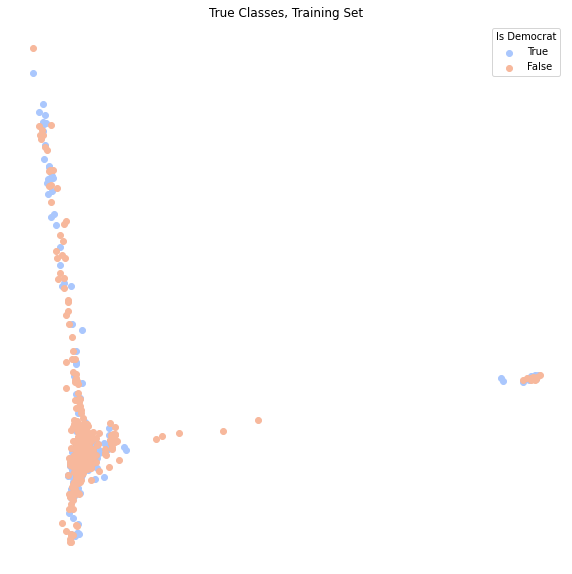

In [155]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Democrat
a = np.stack(train_data_df[train_data_df['is_dem']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Democrat (i.e., Republican)
a = np.stack(train_data_df[train_data_df['is_dem'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Democrat')
plt.title('True Classes, Training Set')
plt.show()

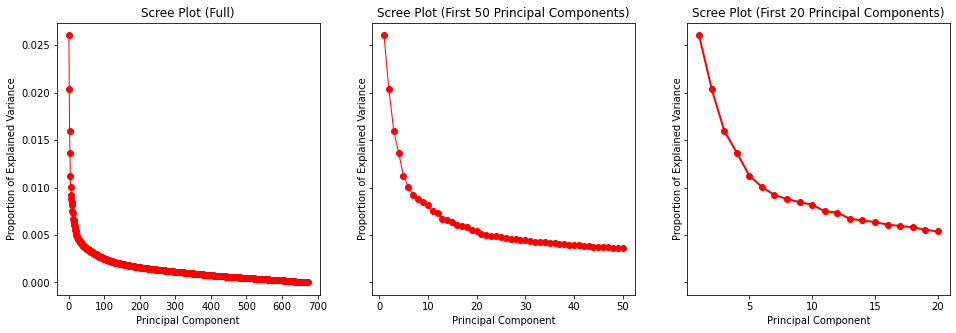

In [157]:
# now let's perform PCA

n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

It seems like the first 10 prinicpal compnents account for a lot of the variance in the data, so we can fit a logistic regression with those.

In [158]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])


In [160]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['is_dem'])

LogisticRegression()

In [162]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['is_dem'])


0.6175595238095238

Our accuracy here is only about 62%, which is pretty low. Let's see how the classifier performs on the test set.

In [164]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['order_text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['is_dem'])

0.6167664670658682

The classifier performs about the same here. Let's try increasing the number of dimensions.

In [165]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['is_dem'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['is_dem']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['is_dem']))

Training:
0.7574404761904762
Testing:
0.7065868263473054


Our classifier improved a lot and is now at 70% for test accuracy! Let's see if 100 principal components gives us something better.

In [166]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['is_dem'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['is_dem']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['is_dem']))

Training:
0.8363095238095238
Testing:
0.7005988023952096


Our training accuracy improved, but our test accuracy did not. We may be headed in the direction of overfitting, but let's try it with more principal components just for fun!

In [169]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['is_dem'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['is_dem']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['is_dem']))

Training:
0.8720238095238095
Testing:
0.7544910179640718


In [167]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['is_dem'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['is_dem']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['is_dem']))

Training:
0.9151785714285714
Testing:
0.7844311377245509


Wow, we actually were able to improve our test accuracy with 400 principal components. Now, let's try adding in a regularization parameter to avoid overfitting. 

In [170]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l2')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['is_dem'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['is_dem']))

0.9285714285714286


In [172]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['is_dem']))


0.7784431137724551


In [193]:
# modified the lucem_illud plot confusion to specify name of column with category
def plotConfusionMatrix(clf, testDF, target_col_name='category', title='Confusion Matrix'):
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))
    mat = sklearn.metrics.confusion_matrix(testDF[target_col_name], predictions)
    seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=testDF[target_col_name].unique(), yticklabels=testDF[target_col_name].unique())
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title(title)
    plt.show()
    plt.close()

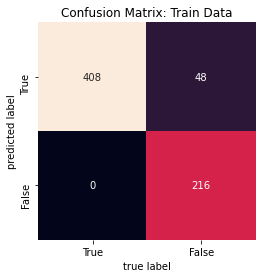

In [195]:
plotConfusionMatrix(logistic_l1, train_data_df, target_col_name='is_dem', title='Confusion Matrix: Train Data')


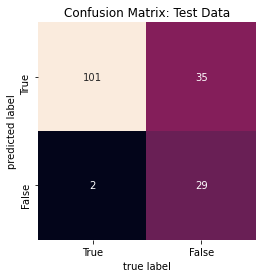

In [194]:
plotConfusionMatrix(logistic_l1, test_data_df, target_col_name='is_dem', title='Confusion Matrix: Test Data')


In [206]:
# modified lucem illud plotMultiROC function to specify target col
def plotMultiROC(clf, testDF, target_col_name='category', title='Receiver Operating Characteristics'):
    #By making the column names variables we can easily use this function on new data sets

    #Get the names of each of the possible classes and the probabiltiess
    classes = clf.classes_
    try:
        probs = clf.predict_proba(np.stack(testDF['vect'], axis=0))
    except AttributeError:
        print("The {} classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.".format(type(clf)))
        return
    predictions = clf.predict(np.stack(testDF['vect'], axis=0))

    #setup axis for plotting
    fig, ax = plt.subplots(figsize = (10,10))

    #We can return the AUC values, in case they are useful
    aucVals = []
    for classIndex, className in enumerate(classes):        #Setup binary classes
        truths = [1 if c == className else 0 for c in testDF[target_col_name]]
        predict = [1 if c == className else 0 for c in predictions]
        scores = probs[:, classIndex]

        #Get the ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(truths, scores)
        auc = sklearn.metrics.auc(fpr, tpr)
        aucVals.append(auc)

        #Plot the class's line
        ax.plot(fpr, tpr, label = "{} (AUC ${:.3f}$)".format(str(className).split(':')[0], auc))

    #Make the plot nice, then display it
    ax.set_title(title)
    plt.plot([0,1], [0,1], color = 'k', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right')
    plt.show()
    plt.close()
    #return aucVals

In [203]:
from sklearn import metrics

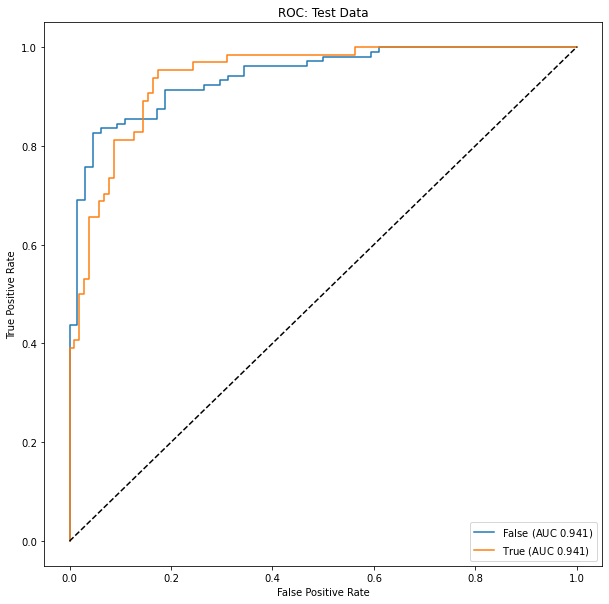

In [208]:
plotMultiROC(logistic_l1, test_data_df, target_col_name='is_dem', title='ROC: Test Data')

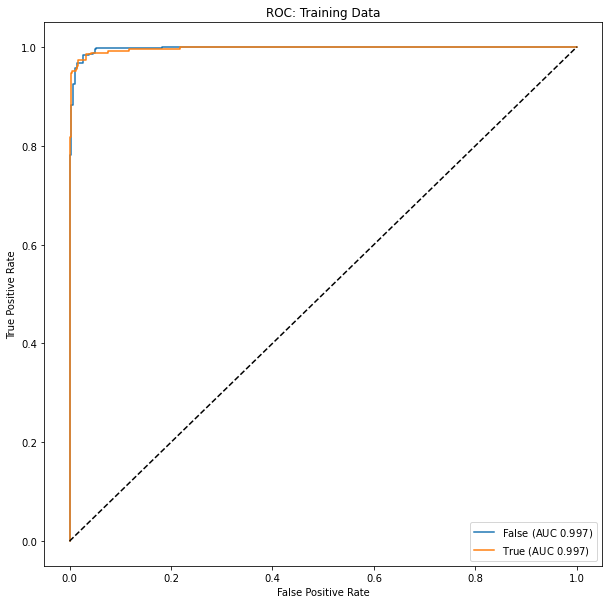

In [209]:
plotMultiROC(logistic_l1, train_data_df, target_col_name='is_dem', title='ROC: Training Data')

Looks like we've maxed out at about 78% accuracy for classifying orders as having come from Democrats vs. Republicans, which isn't terrible. Now, let's look at a Naive Bayes model!

In [173]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['is_dem'])

BernoulliNB()

In [174]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['is_dem']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['is_dem']))

Training:
0.8497023809523809
Testing:
0.7904191616766467


Naive Bayes does a tiny bit better than the logistic regression, giving us test accuracy of 79% compared to 78%.

In [175]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

In [178]:
print('Precision:')
print(sklearn.metrics.precision_score(test_data_df['is_dem'], test_data_df['nb_predict']))
print('Recall:')
print(sklearn.metrics.recall_score(test_data_df['is_dem'], test_data_df['nb_predict']))
print('f1 score:')
print(sklearn.metrics.f1_score(test_data_df['is_dem'], test_data_df['nb_predict']))

Precision:
0.7959183673469388
Recall:
0.609375
f1 score:
0.6902654867256638


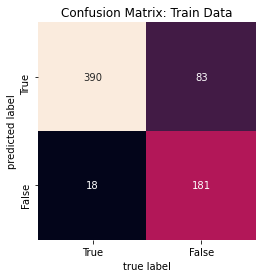

In [197]:
plotConfusionMatrix(naiveBayes, train_data_df, target_col_name='is_dem', title='Confusion Matrix: Train Data')


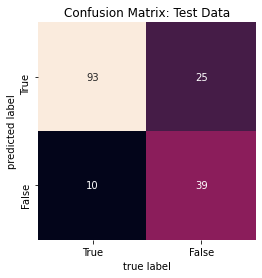

In [196]:
plotConfusionMatrix(naiveBayes, test_data_df, target_col_name='is_dem', title='Confusion Matrix: Test Data')


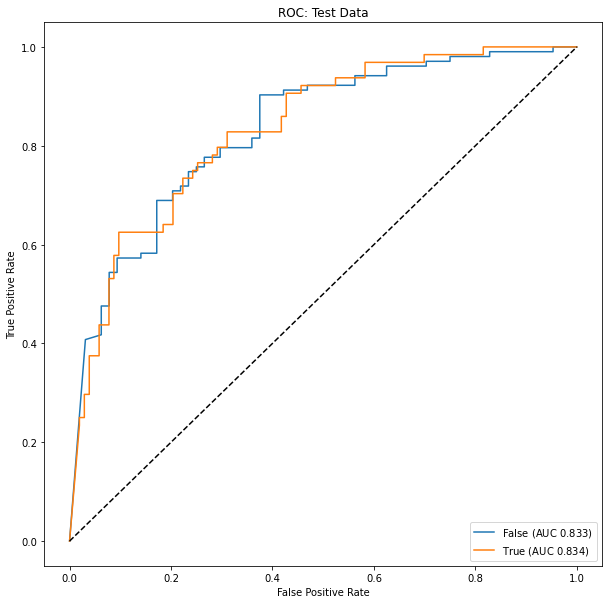

In [210]:
plotMultiROC(naiveBayes, test_data_df, target_col_name='is_dem', title='ROC: Test Data')

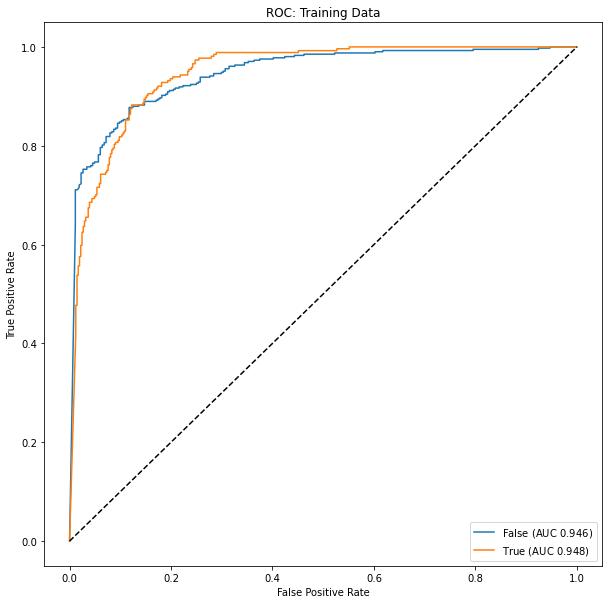

In [211]:
plotMultiROC(naiveBayes, train_data_df, target_col_name='is_dem', title='ROC: Training Data')

The logistic regression performs fairly well, with a maximum accuracy of about 78%. The naive bayes performs a bit better (at 79%), but favors precision over recall and fails to recognize a handful of cases where an order was written by a Democrat. Our logistic regression has very few false negatives, meaning it only tags things as Democrat when they are very likely to be Democrat, but is more likely to predict false negatives (i.e., fail to tag an order as Democrat when it is).

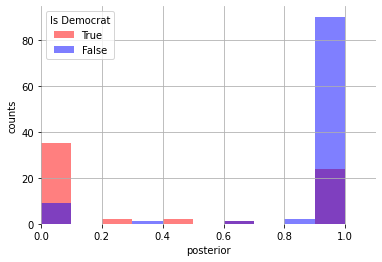

In [179]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['is_dem'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['is_dem'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Democrat")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

In [185]:
test_data_df[['president', 'publication_date','is_dem']]

,president,publication_date,is_dem
7,barack_obama,01/03/2017,True
116,barack_obama,07/05/2013,True
177,barack_obama,10/13/2011,True
1036,donald_trump,02/03/2017,False
129,barack_obama,01/03/2013,True
...,...,...,...
869,donald_trump,07/29/2020,False
920,donald_trump,09/12/2019,False
542,george_w_bush,08/22/2001,False
261,barack_obama,02/24/2009,True


SAY SOMETHING ABOUT THIS ^^

In [181]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Democrat' : [],
    'Democrat_log_prob' : [],
    'Republican' : [],
    'Republican_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Democrat'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Democrat_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Republican'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Republican_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Democrat,Democrat_log_prob,Republican,Republican_log_prob
0,2017,-1.538820,2011,-1.320816
1,instrumentalities,-1.646709,2010,-1.363989
2,americans,-1.725698,level,-1.456362
3,29,-1.841770,2009,-1.489152
4,internal,-1.857274,goals,-1.505959
5,data,-1.889023,2012,-1.594512
6,intelligence,-1.889023,best,-1.594512
7,2003,-1.905283,plans,-1.632253
8,2004,-1.905283,standards,-1.632253
9,2020,-1.905283,developing,-1.651671


It seems the code relied on years that were mentioned as dates for things to be implemented to figure out when Republicans vs. Democrats were in office. Interestingly, the years listed under Democrat are years when Republicans were in office and the years listed under Republican were years when Democrats were in office. These could have been actions of outgoing presidents intended to maintain their party's influence into the next president's term. From Clinton, presidents alternated parties, so it's possible that, say, Obama made executive orders that called for policies to go into effect in 2017 to maintain a degree of Democratic control.

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

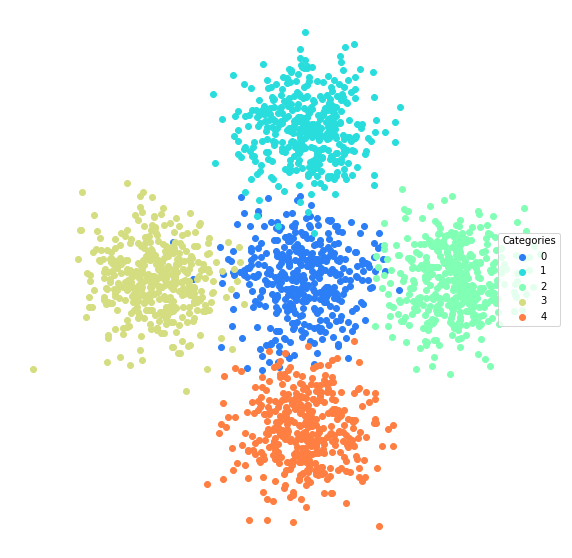

In [198]:
blobs_df = lucem_illud_2020.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud_2020.trainTestSplit(blobs_df)
lucem_illud_2020.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [212]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

To see what's going on visually with the classification: 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

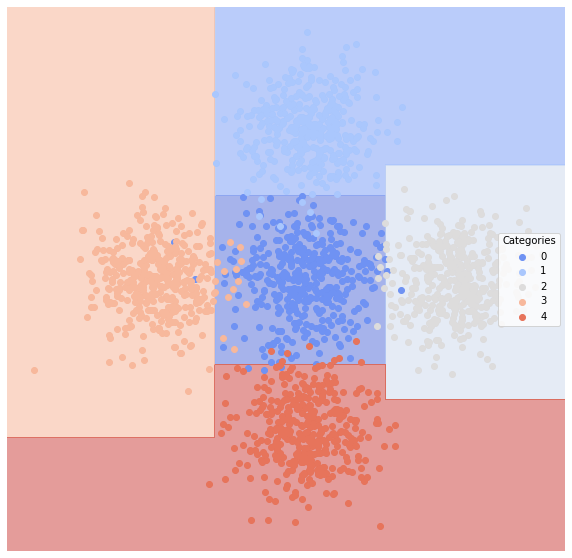

In [213]:
lucem_illud_2020.plotregions(clf_tree, df_exampleTree_train)

In [214]:
lucem_illud_2020.evaluateClassifier(clf_tree, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.034,0.971445,0.871795,0.859030,0.980769
1,0.016,0.964602,1.000000,0.945204,0.929204
2,0.006,0.988130,0.989247,0.972199,0.978723
3,0.010,0.976558,0.988506,0.952572,0.955556
4,0.002,0.994949,1.000000,0.991899,0.989899


Lets look at accuracy:

In [215]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.966

What happens if we trim the tree?

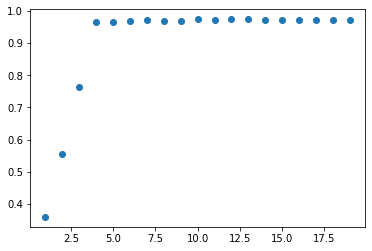

In [216]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [217]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [218]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

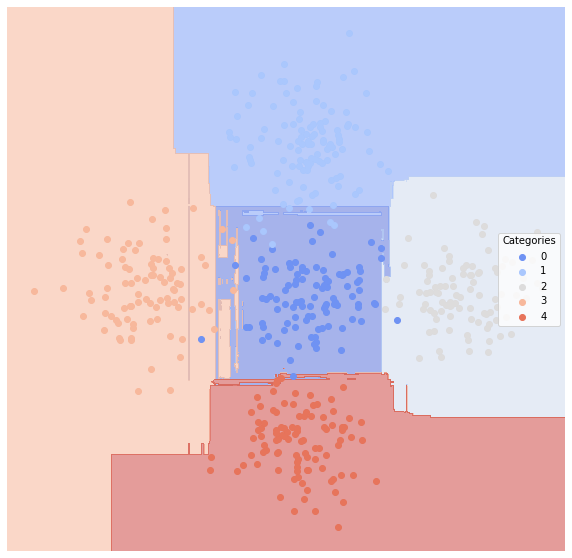

In [219]:
lucem_illud_2020.plotregions(bag, df_exampleTree_test)

In [220]:
lucem_illud_2020.evaluateClassifier(bag, df_exampleTree_test)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
0,0.032,0.969163,0.885965,0.866408,0.971154
1,0.016,0.964602,1.000000,0.945204,0.929204
2,0.004,0.993449,0.989362,0.980837,0.989362
3,0.008,0.982114,0.988636,0.961682,0.966667
4,0.004,0.993703,0.989899,0.981900,0.989899


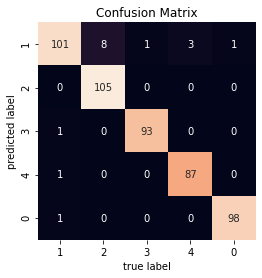

In [221]:
lucem_illud_2020.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

I now change my classification question from the binary of Democrat/Republican to the categorical question of which president (Clinton, Bush, Obama, Trump) wrote the order.

In [222]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)

In [228]:
test_data_df = test_data_df.rename(columns={'president': 'category'})
train_data_df = train_data_df.rename(columns={'president': 'category'})

In [229]:
clf_tree.fit(np.stack(test_data_df['vect'], axis =0), test_data_df['category'])

DecisionTreeClassifier(max_depth=4, random_state=0)

In [226]:
# modify plot regions to take target col name as input
def plotregions(clf, df, h = .01, target_col_name='category'):
    if np.random.choice(df['vect']).shape[0] > 2:
        pca = sklearn.decomposition.PCA(n_components = 2)
        reduced_data = pca.fit_transform(np.stack(df['vect'], axis=0))
        transformedDF = pandas.DataFrame({'vect' : [r for r in reduced_data], target_col_name : df[target_col_name]})
    else:
        transformedDF = df
    catsMap = {c : i for i, c in enumerate(np.unique(df[target_col_name]))}

    fig, ax = plt.subplots(figsize = (10,10))
    ax.axis('off')
    pallet = seaborn.color_palette(palette='coolwarm', n_colors = len(set(transformedDF[target_col_name])))

    if np.random.choice(df['vect']).shape[0] > 2:
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))
        Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    else:
        reduced_data = np.stack(df['vect'], axis=0)
        xx, yy = np.meshgrid(np.arange(1.1 * reduced_data[:,0].min(),
                1.1 * reduced_data[:,0].max(), h),
            np.arange(1.1 * reduced_data[:,1].min(),
                1.1 * reduced_data[:,1].max(), h))

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.vectorize(lambda x: catsMap[x])(Z)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.coolwarm)
    for i, cat in enumerate(set(df[target_col_name])):
        a = np.stack(transformedDF[transformedDF[target_col_name] == cat]['vect'])
        ax.scatter(a[:,0], a[:, 1], c = pallet[catsMap[cat]], label = cat)
    ax.legend(loc = 'center right', title = 'Categories')
    plt.show()
    plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

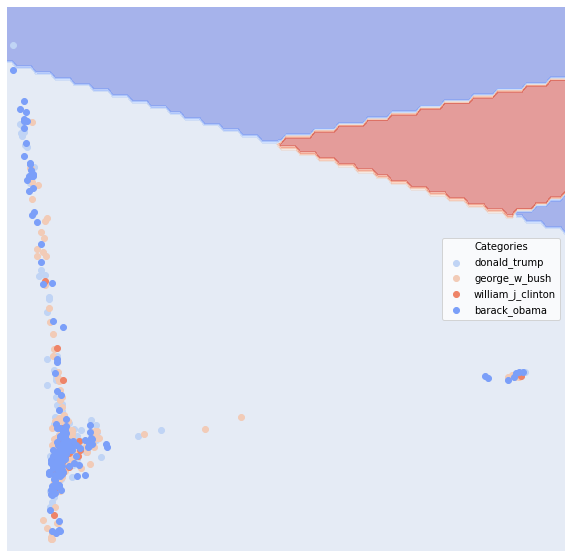

In [230]:
lucem_illud_2020.plotregions(clf_tree, train_data_df)


In [231]:
lucem_illud_2020.evaluateClassifier(clf_tree, test_data_df)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
donald_trump,0.041916,0.918605,1.000000,0.879125,0.837209
george_w_bush,0.227545,0.683333,1.000000,0.594212,0.366667
william_j_clinton,0.000000,1.000000,1.000000,1.000000,1.000000
barack_obama,0.269461,0.795455,0.558824,0.558824,1.000000


In [241]:
sklearn.metrics.f1_score(test_data_df['category'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)), average='micro')


0.7305389221556886

In [232]:
sklearn.metrics.accuracy_score(test_data_df['category'],clf_tree.predict(np.stack(test_data_df['vect'], axis = 0)))


0.7305389221556886

Wow, this does surprisingly well, especially for Clinton and Trump (less so for Bush and Obama, but still decent).

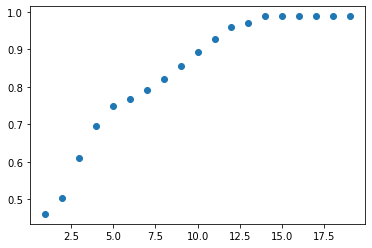

In [233]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])
    score = sklearn.metrics.accuracy_score(test_data_df['category'], tree2.predict(np.stack(test_data_df['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

In [234]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [235]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                  max_samples=0.8, n_estimators=100, random_state=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

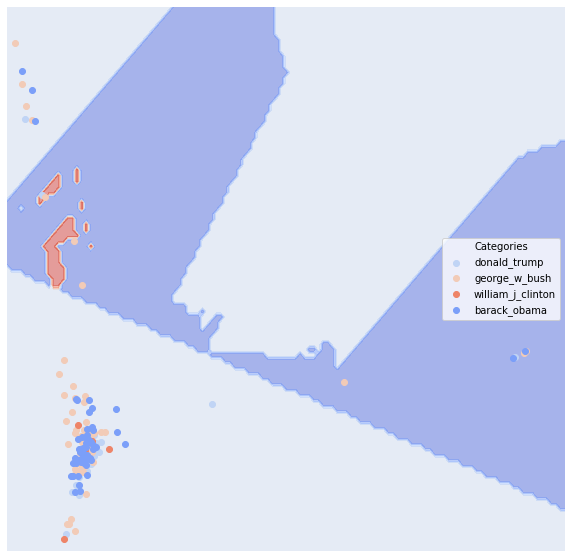

In [237]:
lucem_illud_2020.plotregions(bag, test_data_df)


In [238]:
lucem_illud_2020.evaluateClassifier(bag, test_data_df)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
donald_trump,0.029940,0.949456,0.975000,0.908254,0.906977
george_w_bush,0.071856,0.943925,0.833333,0.833333,1.000000
william_j_clinton,0.000000,1.000000,1.000000,1.000000,1.000000
barack_obama,0.065868,0.907735,0.979167,0.867263,0.824561


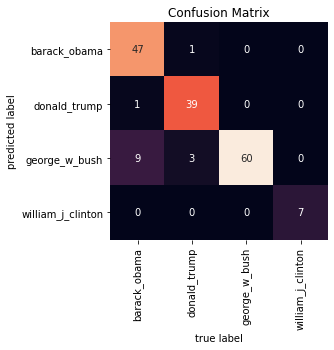

In [239]:
lucem_illud_2020.plotConfusionMatrix(bag, test_data_df)


Both the decision tree and the random forest have extremely low error rates and do a good job of predicting which president an order belongs to. Ensemble learning takes a handful of different models (in this case different decision trees), plugs in the x data and takes a "majority vote" of the classification from each of the different models to determine what the classification should be. Here, the random forest does better than the regular decision tree because it avoids overfitting the model to the training data.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [247]:
newsgroupsDF[:5]

,text,category,source_file,tokenized_text,normalized_text
0,\n\nParadise and salvation are not the same th...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Paradise, and, salvation, are, not, the, same...","[paradise, salvation, thing, salvation, well, ..."
1,\nYou're admitting a lot more than that. You ...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situational, admit,..."
2,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[Jesus, also, recognized, other, holy, days, l...","[jesus, recognize, holy, day, like, passover, ..."
3,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[In, <, lsjc8cINNmc1@saltillo.cs.utexas.edu, >...","[<, lsjc8cinnmc1@saltillo.cs.utexas.edu, >, tu..."
4,"\nI'm sorry, but He does not! Ever read the F...",talk.religion.misc,../data/20news_home/20news-bydate-train/talk.r...,"[I, 'm, sorry, but, He, does, not, Ever, read,...","[be, sorry, read, commandment]"


Make a testing and training set:

In [248]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [249]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [250]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [251]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(n_neighbors=15)

In [252]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
talk.religion.misc,0.355775,0.580379,0.247920,0.212603,0.480645
comp.graphics,0.271619,0.613018,0.509036,0.358509,0.356540
sci.space,0.351132,0.662978,0.412214,0.368985,0.693790
soc.religion.christian,0.271619,0.504237,1.000000,0.280094,0.008475


And lets look at the testing data

In [253]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.2255813953488372


Let's produce another confusion matrix:

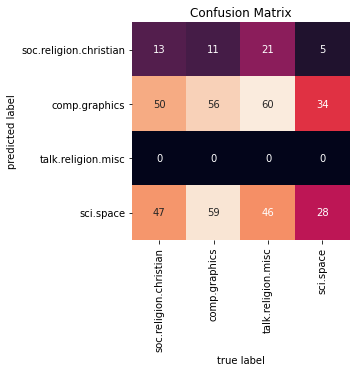

In [254]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

In [255]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [256]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])


KNeighborsClassifier(n_neighbors=15)

In [244]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_data_df)


,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
donald_trump,0.135417,0.793751,0.802817,0.610819,0.644068
george_w_bush,0.218750,0.776644,0.656716,0.582201,0.761905
william_j_clinton,0.063988,0.532609,1.000000,0.129205,0.065217
barack_obama,0.251488,0.737572,0.594595,0.515273,0.706422


In [245]:
print("Testing score:")
print(clf_knearest.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Testing score:
0.5808383233532934


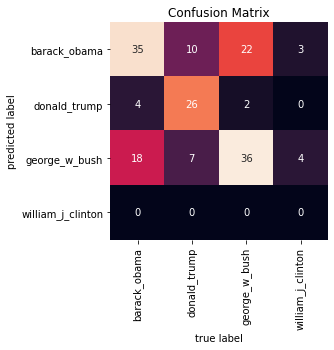

In [246]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_data_df)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

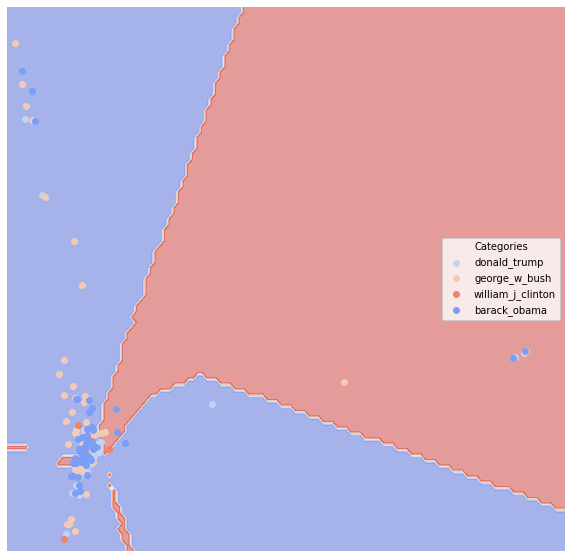

In [257]:
lucem_illud_2020.plotregions(clf_knearest, test_data_df)

Nearest neighbor doesn't do nearly as well as the decision tree or the random forest with this classification problem. Its accuracy is only 58%. We can see from the PCA visualization that it is not able to cleanly separate the categories.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [258]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

We will tf.idf the data to make our vectors:

In [259]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [260]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud_2020.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [261]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(kernel='linear')

...and consider the results:

In [262]:
lucem_illud_2020.evaluateClassifier(clf_svm, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.012539,0.991736,0.950617,0.950617,1.000000
Weeaboo Tales: stories about the extreme fans of japanese culture,0.009404,0.982353,1.000000,0.974110,0.964706
Tales From Tech Support,0.009404,0.993827,0.962025,0.962025,1.000000
Relationships,0.012539,0.975309,1.000000,0.963156,0.950617


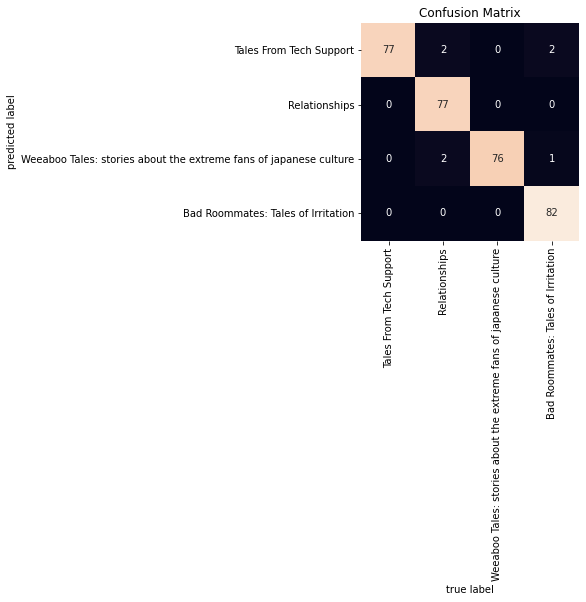

In [263]:
lucem_illud_2020.plotConfusionMatrix(clf_svm, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

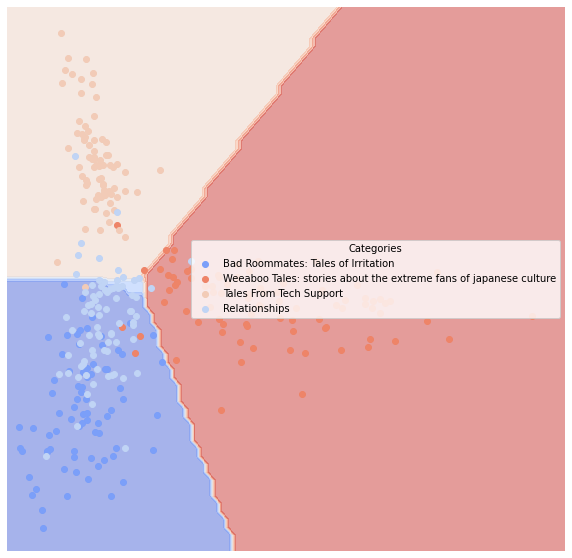

In [264]:
lucem_illud_2020.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [265]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier()

In [266]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_redditDf)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Bad Roommates: Tales of Irritation,0.018809,0.983176,0.938272,0.929221,0.987013
Weeaboo Tales: stories about the extreme fans of japanese culture,0.012539,0.980216,0.987952,0.962487,0.964706
Tales From Tech Support,0.006270,0.995885,0.974359,0.974359,1.000000
Relationships,0.025078,0.958761,0.974026,0.920685,0.925926


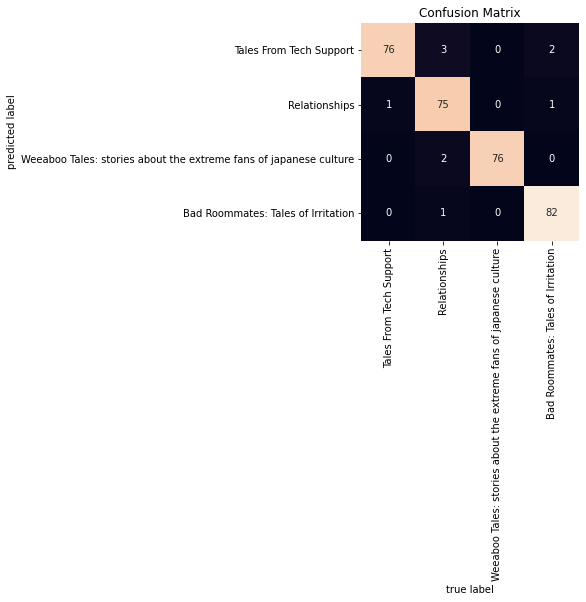

In [267]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_redditDf)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

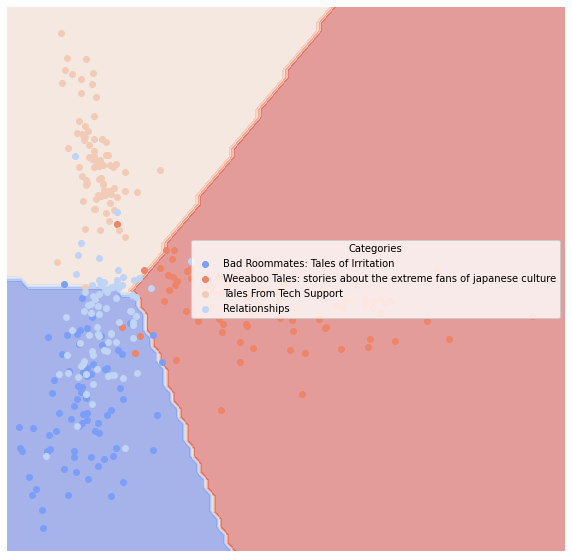

In [268]:
lucem_illud_2020.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [269]:
clf_nn = sklearn.neural_network.MLPClassifier()

In [270]:
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier()

In [271]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_data_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
donald_trump,0.101796,0.870686,0.795455,0.695367,0.813953
george_w_bush,0.083832,0.905296,0.896552,0.824916,0.866667
william_j_clinton,0.011976,0.857143,1.000000,0.726262,0.714286
barack_obama,0.137725,0.853190,0.783333,0.705787,0.824561


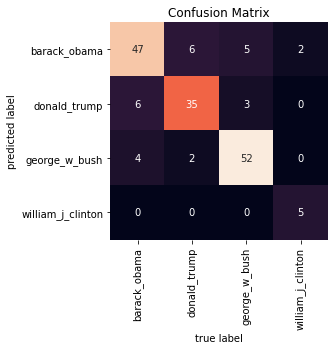

In [272]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_data_df)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

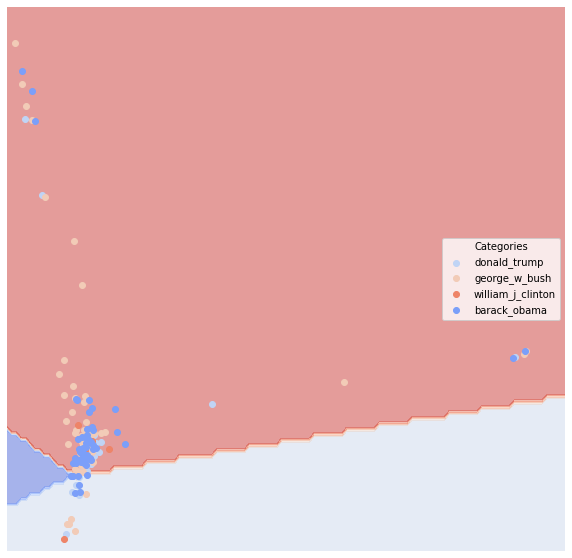

In [273]:
lucem_illud_2020.plotregions(clf_nn, test_data_df)

The neural network performs much better than k-nearest-neighbors but doesn't perform quite as well as the decision tree or random forest classifiers.